# Blogs recommendation model using doc2vec

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import pandas as pd

from tqdm import tqdm
from bs4 import BeautifulSoup
from utils import *

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

tqdm.pandas(desc="Preprocess dataset")
%matplotlib inline

In [3]:
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
logger = logging.getLogger()

# Load Dataset

In [4]:
blogs_df = pd.read_csv("data/blogs_data.csv")

In [5]:
blogs_df.head() # This data is already preprocess and normalize in English

,id,title,content,slug,data,lang,normalize_data
0,5173,Why Scalability Matters for Your App,Building an app is an extensive process. From ...,why-scalability-matters-for-your-app,Why Scalability Matters for Your App Building ...,en,Why Scalability Matters for Your App Building ...
1,5174,Is a Scrum Agile Development Process Right for...,A Brief History of Scrum Agile Development: \n...,is-a-scrum-agile-development-process-right-for...,Is a Scrum Agile Development Process Right for...,en,Is a Scrum Agile Development Process Right for...
2,5175,How to Make Your App Irresistible Through User...,Guessing is a part of life—and it’s necessary....,how-to-make-your-app-irresistible-through-user...,How to Make Your App Irresistible Through User...,en,How to Make Your App Irresistible Through User...
3,5176,5 Product Manager MUSTS for Creating a Success...,Product management is a tough job. You must tr...,5-product-manager-musts-for-creating-a-success...,5 Product Manager MUSTS for Creating a Success...,en,5 Product Manager MUSTS for Creating a Success...
4,5177,7 Key Questions to Ask Your Prospective App De...,From the moment you decide to move forward wit...,7-key-questions-to-ask-prospective-app-develop...,7 Key Questions to Ask Your Prospective App De...,en,7 Key Questions to Ask Your Prospective App De...


In [6]:
print(blogs_df["normalize_data"][0])

Why Scalability Matters for Your App Building an app is an extensive process. From a fresh idea to a marketable product, the journey is filled with ups and downs. So, when you (hopefully) build that successful app, the last thing you want is for it to hit a dead end.
However, that’s, unfortunately, the way it usually goes. You might think that accelerated growth is totally positive, as users are downloading your app at a record rate. But, an app that isn’t designed and developed to seamlessly handle this explosive growth will eventually end up being a failure.
Consider this: is your app, as it stands today, able to scale up to exponential growth? If you have any doubts, you need to seriously consider this scalability issue.

What is app scalability?
Scalability is the ability of your app to handle a growing number of customers, clients and/or users. It also pertains to the ability of your current or future developer to maintain the app. Consider the possibility that your app isn’t curr

# Preprocess data for training

In [7]:
regex = get_regex_expression()
regex

'(https?:\\/\\/.*[\\r\\n])|(\\#[^\\s]*)|(\\@[^\\s]*)|(author)|(\\S*@\\S+)|([^a-zA-Z0-9À-ÿ\\u00f1\\u00d1\\s])'

In [8]:
example = preprocess_data(blogs_df["normalize_data"][0], regex, 
                          removing_stops=True, lemmatize=True)
print(example)

['scalability', 'matter', 'app', 'build', 'app', 'extensive', 'process', 'fresh', 'idea', 'marketable', 'product', 'journey', 'fill', 'up', 'down', 'hopefully', 'build', 'successful', 'app', 'thing', 'want', 'hit', 'dead', 'end', 'unfortunately', 'way', 'usually', 'go', 'think', 'accelerated', 'growth', 'totally', 'positive', 'user', 'download', 'app', 'record', 'rate', 'app', 'isn', 'design', 'develop', 'seamlessly', 'handle', 'explosive', 'growth', 'eventually', 'end', 'failure', 'consider', 'app', 'stand', 'today', 'able', 'scale', 'exponential', 'growth', 'doubt', 'need', 'seriously', 'consider', 'scalability', 'issue', 'app', 'scalability', 'scalability', 'ability', 'app', 'handle', 'grow', 'number', 'customer', 'client', 'user', 'pertain', 'ability', 'current', 'future', 'developer', 'maintain', 'app', 'consider', 'possibility', 'app', 'isn', 'currently', 'scalable', 'prepared', 'scramble', 'add', 'necessary', 'additional', 'feature', 'flexible', 'coding', 'keep', 'app', 'run', '

In [9]:
# Train data doing lemmatization and removing stopswords
train_data = [preprocess_data(normalize_data, regex, True, True) 
                for normalize_data in tqdm(blogs_df["normalize_data"].values)]

100%|██████████| 458/458 [00:49<00:00,  9.24it/s]


In [10]:
print(train_data[0])

['scalability', 'matter', 'app', 'build', 'app', 'extensive', 'process', 'fresh', 'idea', 'marketable', 'product', 'journey', 'fill', 'up', 'down', 'hopefully', 'build', 'successful', 'app', 'thing', 'want', 'hit', 'dead', 'end', 'unfortunately', 'way', 'usually', 'go', 'think', 'accelerated', 'growth', 'totally', 'positive', 'user', 'download', 'app', 'record', 'rate', 'app', 'isn', 'design', 'develop', 'seamlessly', 'handle', 'explosive', 'growth', 'eventually', 'end', 'failure', 'consider', 'app', 'stand', 'today', 'able', 'scale', 'exponential', 'growth', 'doubt', 'need', 'seriously', 'consider', 'scalability', 'issue', 'app', 'scalability', 'scalability', 'ability', 'app', 'handle', 'grow', 'number', 'customer', 'client', 'user', 'pertain', 'ability', 'current', 'future', 'developer', 'maintain', 'app', 'consider', 'possibility', 'app', 'isn', 'currently', 'scalable', 'prepared', 'scramble', 'add', 'necessary', 'additional', 'feature', 'flexible', 'coding', 'keep', 'app', 'run', '

# Doc2Vec model with gensim

```
Parameters
----------
documents : iterable of list of :class:`~gensim.models.doc2vec.TaggedDocument`

dm : {1,0}, optional
    Defines the training algorithm. If `dm=1`, 'distributed memory' (PV-DM) is used.
    Otherwise, `distributed bag of words` (PV-DBOW) is employed.

vector_size : int, optional
    Dimensionality of the feature vectors.

window : int, optional
    The maximum distance between the current and predicted word within a sentence.

alpha : float, optional
    The initial learning rate.

min_alpha : float, optional
    Learning rate will linearly drop to `min_alpha` as training progresses.

min_count : int, optional
    Ignores all words with total frequency lower than this.

max_vocab_size : int, optional
    Limits the RAM during vocabulary building; if there are more unique
    words than this, then prune the infrequent ones. Every 10 million word types need about 1GB of RAM.

sample : float, optional
    The threshold for configuring which higher-frequency words are randomly downsampled,
    useful range is (0, 1e-5).

workers : int, optional
    Use these many worker threads to train the model (=faster training with multicore machines).

epochs : int, optional
    Number of iterations (epochs) over the corpus.

hs : {1,0}, optional
    If 1, hierarchical softmax will be used for model training.
    If set to 0, and `negative` is non-zero, negative sampling will be used.

negative : int, optional
    If > 0, negative sampling will be used, the int for negative specifies how many "noise words"
    should be drawn (usually between 5-20).
    If set to 0, no negative sampling is used.

ns_exponent : float, optional
    The exponent used to shape the negative sampling distribution. A value of 1.0 samples exactly in
    proportion to the frequencies, 0.0 samples all words equally, while a negative value samples low 
    frequency words more than high-frequency words.

dm_mean : {1,0}, optional
    If 0 , use the sum of the context word vectors. If 1, use the mean.
    Only applies when `dm` is used in non-concatenative mode.

dm_concat : {1,0}, optional
    If 1, use concatenation of context vectors rather than sum/average;
    Note concatenation results in a much-larger model, as the input
    is no longer the size of one (sampled or arithmetically combined) word vector, but the
    size of the tag(s) and all words in the context strung together.

dm_tag_count : int, optional
    Expected constant number of document tags per document, when using
    dm_concat mode.

dbow_words : {1,0}, optional
    If set to 1 trains word-vectors (in skip-gram fashion) simultaneous with DBOW
    doc-vector training; If 0, only trains doc-vectors (faster).
```

## Prepare the data

In [11]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [14]:
blogs = [TaggedDocument(blog, [i]) for i, blog in enumerate(train_data)]

## Hyperparameters

In [16]:
import multiprocessing
cpu_counts = multiprocessing.cpu_count()

In [72]:
hyperparameters = {"dm":1, "size":300, "window":5, "sample": 1e-4, 
                   "workers": cpu_counts, "epochs": 140, "hs":0, "negative":15,
                   "ns_exponent": -0.5, "dbow_words":1}

In [73]:
doc2vec_model = Doc2Vec(**hyperparameters)

## Build vocab

In [74]:
doc2vec_model.build_vocab(blogs)

2020-06-08 22:06:28,505 : INFO : collecting all words and their counts
2020-06-08 22:06:28,506 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-06-08 22:06:28,539 : INFO : collected 10286 word types and 458 unique tags from a corpus of 458 examples and 224885 words
2020-06-08 22:06:28,540 : INFO : Loading a fresh vocabulary
2020-06-08 22:06:28,665 : INFO : effective_min_count=5 retains 3697 unique words (35% of original 10286, drops 6589)
2020-06-08 22:06:28,666 : INFO : effective_min_count=5 leaves 213793 word corpus (95% of original 224885, drops 11092)
2020-06-08 22:06:28,679 : INFO : deleting the raw counts dictionary of 10286 items
2020-06-08 22:06:28,680 : INFO : sample=0.0001 downsamples 804 most-common words
2020-06-08 22:06:28,680 : INFO : downsampling leaves estimated 112431 word corpus (52.6% of prior 213793)
2020-06-08 22:06:28,693 : INFO : estimated required memory for 3697 words and 300 dimensions: 11270900 bytes
2020-06-08 22:06:28,694

## Train doc2vec model

In [75]:
doc2vec_model.train(blogs, total_examples=doc2vec_model.corpus_count, 
                   epochs=doc2vec_model.epochs)

2020-06-08 22:06:30,146 : INFO : training model with 8 workers on 3697 vocabulary and 300 features, using sg=0 hs=0 sample=0.0001 negative=15 window=5
2020-06-08 22:06:30,353 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:30,355 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:30,369 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:30,370 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:30,379 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:30,383 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:30,387 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:30,399 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:30,399 : INFO : EPOCH - 1 : training on 224885 raw words (113005 effective words) took 0.2s, 460618 effe

2020-06-08 22:06:32,727 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:32,728 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:32,731 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:32,737 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:32,738 : INFO : EPOCH - 10 : training on 224885 raw words (112943 effective words) took 0.3s, 424047 effective words/s
2020-06-08 22:06:33,017 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:33,024 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:33,038 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:33,044 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:33,046 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:33,052 : INFO : worker threa

2020-06-08 22:06:35,402 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:35,403 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:35,407 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:35,409 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:35,425 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:35,430 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:35,432 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:35,436 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:35,437 : INFO : EPOCH - 20 : training on 224885 raw words (113059 effective words) took 0.3s, 416474 effective words/s
2020-06-08 22:06:35,633 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:35,647 : INFO : worker threa

2020-06-08 22:06:37,722 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:37,723 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:37,727 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:37,728 : INFO : EPOCH - 29 : training on 224885 raw words (112774 effective words) took 0.3s, 442325 effective words/s
2020-06-08 22:06:37,924 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:37,929 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:37,936 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:37,944 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:37,948 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:37,955 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:37,956 : INFO : worker threa

2020-06-08 22:06:40,296 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:40,298 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:40,310 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:40,320 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:40,322 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:40,322 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:40,329 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:40,329 : INFO : EPOCH - 39 : training on 224885 raw words (112897 effective words) took 0.3s, 405853 effective words/s
2020-06-08 22:06:40,550 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:40,551 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:40,564 : INFO : worker threa

2020-06-08 22:06:42,501 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:42,505 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:42,506 : INFO : EPOCH - 48 : training on 224885 raw words (112925 effective words) took 0.2s, 483717 effective words/s
2020-06-08 22:06:42,696 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:42,706 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:42,710 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:42,712 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:42,722 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:42,727 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:42,728 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:42,733 : INFO : worker threa

2020-06-08 22:06:44,850 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:44,853 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:44,857 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:44,858 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:44,866 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:44,869 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:44,869 : INFO : EPOCH - 58 : training on 224885 raw words (113016 effective words) took 0.2s, 519455 effective words/s
2020-06-08 22:06:45,051 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:45,059 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:45,063 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:45,065 : INFO : worker threa

2020-06-08 22:06:46,851 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:46,851 : INFO : EPOCH - 67 : training on 224885 raw words (112731 effective words) took 0.2s, 523758 effective words/s
2020-06-08 22:06:47,096 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:47,108 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:47,117 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:47,121 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:47,123 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:47,135 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:47,138 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:47,142 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:47,144 : INFO : EPOCH - 68 :

2020-06-08 22:06:49,231 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:49,233 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:49,238 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:49,240 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:49,244 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:49,244 : INFO : EPOCH - 77 : training on 224885 raw words (113375 effective words) took 0.2s, 519824 effective words/s
2020-06-08 22:06:49,446 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:49,460 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:49,465 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:49,469 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:49,475 : INFO : worker threa

2020-06-08 22:06:51,585 : INFO : EPOCH - 86 : training on 224885 raw words (113021 effective words) took 0.3s, 440266 effective words/s
2020-06-08 22:06:51,797 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:51,811 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:51,814 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:51,820 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:51,830 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:51,836 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:51,837 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:51,840 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:51,841 : INFO : EPOCH - 87 : training on 224885 raw words (112871 effective words) took 0.3s, 449461 effective words/s


2020-06-08 22:06:54,239 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:54,245 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:54,249 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:54,256 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:54,257 : INFO : EPOCH - 96 : training on 224885 raw words (113015 effective words) took 0.3s, 424479 effective words/s
2020-06-08 22:06:54,471 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:54,481 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:54,481 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:54,485 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:54,493 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:54,497 : INFO : worker threa

2020-06-08 22:06:56,795 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:56,808 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:56,812 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:56,819 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:56,824 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:56,838 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:56,840 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:56,842 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:56,844 : INFO : EPOCH - 106 : training on 224885 raw words (112708 effective words) took 0.3s, 418916 effective words/s
2020-06-08 22:06:57,053 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:57,061 : INFO : worker thre

2020-06-08 22:06:59,434 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:59,442 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:06:59,448 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:06:59,449 : INFO : EPOCH - 115 : training on 224885 raw words (112796 effective words) took 0.2s, 457051 effective words/s
2020-06-08 22:06:59,645 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:06:59,651 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:06:59,663 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:06:59,666 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:06:59,674 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:06:59,679 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:06:59,681 : INFO : worker thre

2020-06-08 22:07:02,079 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:07:02,091 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:07:02,096 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:07:02,103 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:07:02,110 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:07:02,117 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:07:02,118 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:07:02,125 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:07:02,126 : INFO : EPOCH - 125 : training on 224885 raw words (112827 effective words) took 0.2s, 454318 effective words/s
2020-06-08 22:07:02,329 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:07:02,333 : INFO : worker thre

2020-06-08 22:07:04,475 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:07:04,476 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-08 22:07:04,480 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-08 22:07:04,481 : INFO : EPOCH - 134 : training on 224885 raw words (112834 effective words) took 0.3s, 442754 effective words/s
2020-06-08 22:07:04,698 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-08 22:07:04,701 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-08 22:07:04,707 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-08 22:07:04,718 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-08 22:07:04,726 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-08 22:07:04,733 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-08 22:07:04,744 : INFO : worker thre

## Test similarity words

In [76]:
doc2vec_model.wv.most_similar("ai")

2020-06-08 22:07:06,103 : INFO : precomputing L2-norms of word weight vectors


[('intelligence', 0.4775191843509674),
 ('artificial', 0.45550036430358887),
 ('ml', 0.38382935523986816),
 ('asi', 0.38144707679748535),
 ('military', 0.3594433665275574),
 ('robot', 0.3157636225223541),
 ('robotic', 0.31268125772476196),
 ('statistical', 0.30028852820396423),
 ('diagnostic', 0.29503488540649414),
 ('machine', 0.2830173969268799)]

In [77]:
doc2vec_model.wv.most_similar("devops")

[('philosophy', 0.5078437328338623),
 ('efficiently', 0.3790454864501953),
 ('operations', 0.37144097685813904),
 ('aws', 0.3702588677406311),
 ('velocity', 0.3277755677700043),
 ('team', 0.3193727731704712),
 ('sales', 0.3146997392177582),
 ('unleash', 0.3090924024581909),
 ('ujjwal', 0.30899935960769653),
 ('stack', 0.3068646788597107)]

In [78]:
doc2vec_model.wv.most_similar("python")

[('con', 0.45572102069854736),
 ('pro', 0.4394899606704712),
 ('ruby', 0.41914254426956177),
 ('standpoint', 0.3904948830604553),
 ('pros', 0.3889194130897522),
 ('continued', 0.3874802589416504),
 ('sponsor', 0.3873278498649597),
 ('frontend', 0.3466348648071289),
 ('infographic', 0.3352107107639313),
 ('slowdown', 0.332633912563324)]

In [79]:
doc2vec_model.wv.most_similar("java")

[('portability', 0.43195492029190063),
 ('ee', 0.4225630760192871),
 ('characterize', 0.405001163482666),
 ('swift', 0.40130263566970825),
 ('compatible', 0.392111599445343),
 ('mcommerce', 0.3736405670642853),
 ('potent', 0.3652733266353607),
 ('tringas', 0.35666483640670776),
 ('objective', 0.3507755398750305),
 ('library', 0.35048121213912964)]

## Visualize words embeddings

In [84]:
word_matrix = doc2vec_model.wv[doc2vec_model.wv.vocab]

### Truncated svd to reduce dimension down to 50

In [85]:
from sklearn.decomposition import TruncatedSVD
truncated_svd = TruncatedSVD(n_components=50)

In [87]:
word_matrix_truncated = truncated_svd.fit_transform(word_matrix)

### tsne manifold to reduce dimension down to 2

In [88]:
from sklearn.manifold import TSNE

In [89]:
matrix_ = TSNE(perplexity=50).fit_transform(word_matrix_truncated)

In [90]:
vocab = np.array(list(doc2vec_model.wv.vocab.keys()))

In [91]:
vocab[100:120]

array(['downtime', 'sacrifice', 'come', 'campaign', 'confident',
       'reliability', 'advantage', 'holiday', 'event', 'black', 'friday',
       'etc', 'usage', 'increase', 'offer', 'special', 'deal', 'quick',
       'type', 'moment'], dtype='<U16')

### Visualize words

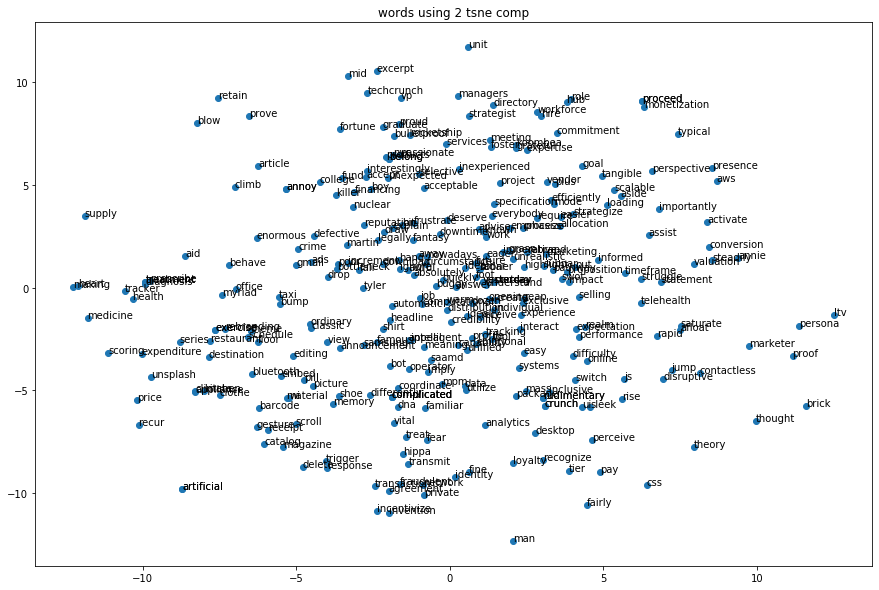

In [92]:
%matplotlib inline
visualize_words_embedding(matrix_, vocab, total=300, width=15, height=10)

## Visualize blogs embedding

In [95]:
blog_matrix = doc2vec_model.docvecs.vectors_docs

### Trucated svd to reduce dimension down to 50

In [96]:
blog_matrix_truncated = TruncatedSVD(n_components=50).fit_transform(blog_matrix)

### Tsne manifold to reduce dimension down to 2

In [97]:
blog_matrix_tsne = TSNE(n_components=2).fit_transform(blog_matrix_truncated)

### Visualize blogs

In [98]:
from sklearn.cluster import KMeans

In [99]:
clusters = KMeans(n_clusters=25).fit_predict(blog_matrix_tsne)

In [102]:
import pickle

TFIDF_MATRIX = pickle.load(open("model/tfidf_unigrams.pickle", "rb"))
vocab_ = pickle.load(open("model/vocab_unigrams.pickle", "rb"))

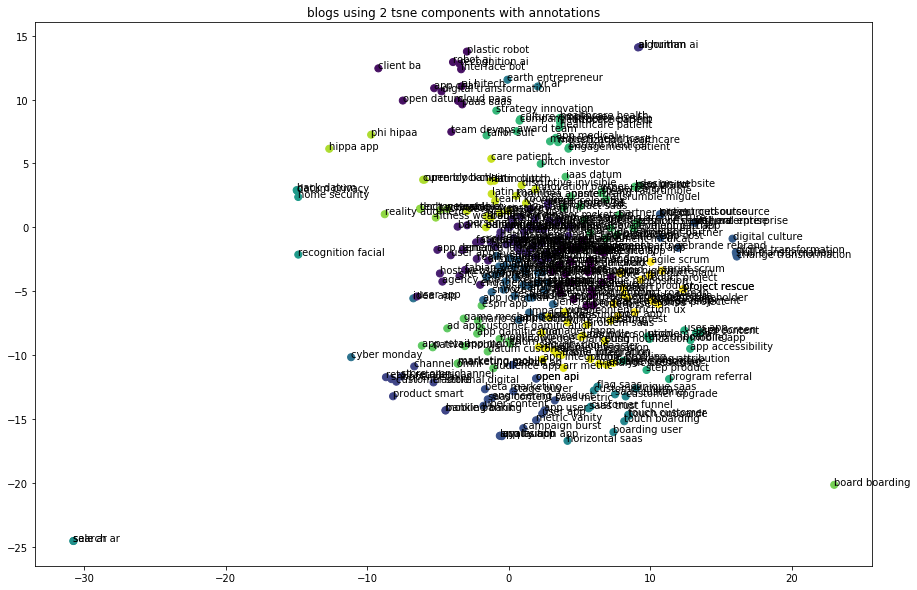

In [109]:
%matplotlib inline
plots_blogs_embedding(TFIDF_MATRIX, blog_matrix_tsne, vocab_, clusters, width=15, height=10)

# Similarity Query

In [110]:
from gensim.summarization import summarize

## Pick a blog and summarize using gensim

In [111]:
print(blogs_df.title[455].upper())
print(summarize(blogs_df.normalize_data[455]))

2020-06-08 22:30:56,439 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-08 22:30:56,441 : INFO : built Dictionary(329 unique tokens: ['bad', 'covid', 'depress', 'econom', 'enter']...) from 82 documents (total 573 corpus positions)
2020-06-08 22:30:56,442 : INFO : Building graph
2020-06-08 22:30:56,443 : INFO : Filling graph
2020-06-08 22:30:56,454 : INFO : Removing unreachable nodes of graph
2020-06-08 22:30:56,458 : INFO : Pagerank graph
2020-06-08 22:30:56,466 : INFO : Sorting pagerank scores


FINTECH TRENDS 2020: THE GOOD, THE BAD, AND THE UGLY
FinTech Trends 2020: The Good, the Bad, and the Ugly Due to the Covid-19 pandemic, the world is entering an economic turmoil not seen since the Great Depression.
Governments all over the world are implementing generous aid programs to help companies and people, but uncertainty prevails.
FinTech, a sector that was performing great before Covid-19, is at the crossroads between surviving the crisis and a universe of opportunities.
In this post we analyze some of the most important FinTech trends that investors and managers should keep on their radar if they wish to stay afloat and come out of the crisis stronger.
Although some FinTech companies are struggling due to the economy’s overall impact, it is safe to say that the majority continue to operate at levels of performance equal to or above before the pandemic.
Some FinTech real estate and insurance companies seem to be having a hard time, although this seems more of a temporary issue

In [119]:
import scipy

query = preprocess_data(blogs_df.normalize_data[455], regex, True, True)

query_embedding = doc2vec_model.infer_vector(query)

# Find the closest 3 sentences of the corpus for each query sentence based on cosine similarity
number_top_matches = 3 #@param {type: "number"}

print("Semantic Search Resutls")

distances = scipy.spatial.distance.cdist([query_embedding], blog_matrix, "cosine")[0]
results = zip(range(len(distances)), distances)
results = sorted(results, key=lambda x: x[1])
results = [(idx, 1-dis) for idx, dis in results]

values_ = [val[0] for val in results]
results[:3]

Semantic Search Resutls


[(455, 0.9774652381146378),
 (452, 0.4487567404914792),
 (450, 0.44694607048697144)]

In [120]:
print(blogs_df.title[values_[0]].upper())
print(summarize(blogs_df.normalize_data[values_[0]]))
print("\n")
print(blogs_df.title[values_[1]].upper())
print(summarize(blogs_df.normalize_data[values_[1]]))
print("\n")
print(blogs_df.title[values_[2]].upper())
print(summarize(blogs_df.normalize_data[values_[2]]))

2020-06-08 22:40:54,137 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-08 22:40:54,139 : INFO : built Dictionary(329 unique tokens: ['bad', 'covid', 'depress', 'econom', 'enter']...) from 82 documents (total 573 corpus positions)
2020-06-08 22:40:54,140 : INFO : Building graph
2020-06-08 22:40:54,141 : INFO : Filling graph
2020-06-08 22:40:54,149 : INFO : Removing unreachable nodes of graph
2020-06-08 22:40:54,150 : INFO : Pagerank graph
2020-06-08 22:40:54,155 : INFO : Sorting pagerank scores
2020-06-08 22:40:54,161 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-08 22:40:54,163 : INFO : built Dictionary(279 unique tokens: ['compani', 'crisi', 'current', 'innov', 'know']...) from 64 documents (total 478 corpus positions)
2020-06-08 22:40:54,164 : INFO : Building graph
2020-06-08 22:40:54,164 : INFO : Filling graph
2020-06-08 22:40:54,171 : INFO : Removing unreachable nodes of graph
2020-06-08 22:40:54,171 : INFO : Pagerank graph
2020-06-0

FINTECH TRENDS 2020: THE GOOD, THE BAD, AND THE UGLY
FinTech Trends 2020: The Good, the Bad, and the Ugly Due to the Covid-19 pandemic, the world is entering an economic turmoil not seen since the Great Depression.
Governments all over the world are implementing generous aid programs to help companies and people, but uncertainty prevails.
FinTech, a sector that was performing great before Covid-19, is at the crossroads between surviving the crisis and a universe of opportunities.
In this post we analyze some of the most important FinTech trends that investors and managers should keep on their radar if they wish to stay afloat and come out of the crisis stronger.
Although some FinTech companies are struggling due to the economy’s overall impact, it is safe to say that the majority continue to operate at levels of performance equal to or above before the pandemic.
Some FinTech real estate and insurance companies seem to be having a hard time, although this seems more of a temporary issue